In [7]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin
import pkg_resources
import yaml

import seaborn as sns
import arviz as az

def get_ci(x):
    return az.hdi(x.values.ravel())

In [2]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    if n_voxels == 1:
        key = 'decoded_pdfs.volume.cv_voxel_selection'
    else:
        key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [20]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=False, exclude_outliers=True)]
sessions = [1]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr', 'NPC12r']
n_voxels = [1, 100]
natural_space = [False]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

pred = pd.concat(pred)


df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')

r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

  0%|          | 0/292 [00:00<?, ?it/s]

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:56: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_5538/1217705090.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [21]:
import arviz as az
idata = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-5_everyone_trace.netcdf')

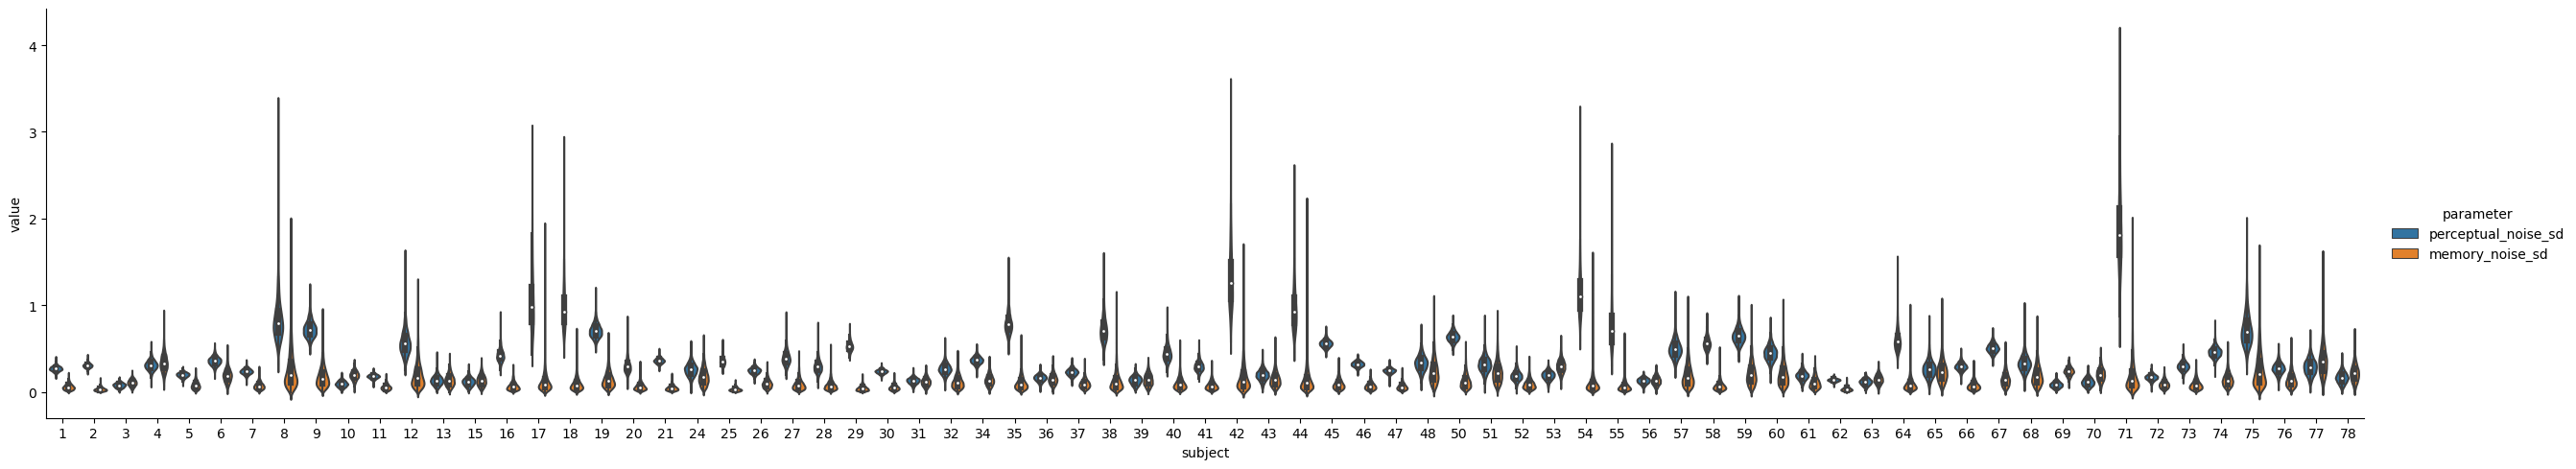

In [22]:
perceptual_noise_sd = idata.posterior['perceptual_noise_sd'].to_dataframe()
memory_noise_sd = idata.posterior['memory_noise_sd'].to_dataframe()

evidence_sd = pd.concat((perceptual_noise_sd, memory_noise_sd), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')

# Make sure that the markers do not get connected
sns.catplot(x='subject', y='value', hue='parameter', data=evidence_sd.reset_index(), kind='violin', errorbar=get_ci, aspect=5, )

In [23]:
mean_evidence_sd = evidence_sd.groupby(['subject', 'parameter']).mean()
pingouin.corr(*mean_evidence_sd.unstack('parameter').values.T)

,n,r,CI95%,p-val,BF10,power
pearson,73,0.062438,"[-0.17, 0.29]",0.599737,0.167,0.08204


In [24]:
mean_evidence_sd.unstack(['parameter']).describe()

value                    
parameter memory_noise_sd perceptual_noise_sd
count           73.000000           73.000000
mean             0.137385            0.419433
std              0.071800            0.321437
min              0.034252            0.080420
25%              0.081226            0.197904
50%              0.124869            0.308257
75%              0.186335            0.561701
max              0.359728            1.876355

In [25]:
def plot_scatter_with_errors(data, xlabel='Vertex', ylabel='IPS', **kwargs):

    x = data[('mean', xlabel)]
    y = data[('mean', ylabel)] 

    xerr_min = x - data['ci_min', xlabel]
    xerr_max = data['ci_max', xlabel] - x

    yerr_min = y - data['ci_min', ylabel]
    yerr_max = data['ci_max', ylabel] - y


    plt.errorbar(x, y, [yerr_min, yerr_max], [xerr_min, xerr_max], fmt='.', markersize=0, alpha=0.5, **kwargs)
    plt.scatter(data[('mean', xlabel)], data[('mean', ylabel)], marker='.', s=50, **kwargs)


def plot_identity_line(*args, **kwargs):

    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    x0 = (xlim[0] + ylim[0]) / 2.
    x1 = (xlim[1] + ylim[1]) / 2.

    plt.plot([x0, x1], [x0, x1], c='k', ls='--')


    

In [26]:
mean_pars = evidence_sd.groupby(['subject', 'parameter'])['value'].mean().to_frame('mean')
ci_pars = evidence_sd.groupby(['subject', 'parameter'])['value'].apply(lambda x: pd.Series(az.hdi(x.values.ravel(), .95), index=pd.Index(['ci_min', 'ci_max']))).to_frame('value').unstack(-1)['value']

par_stats = mean_pars.join(ci_pars)

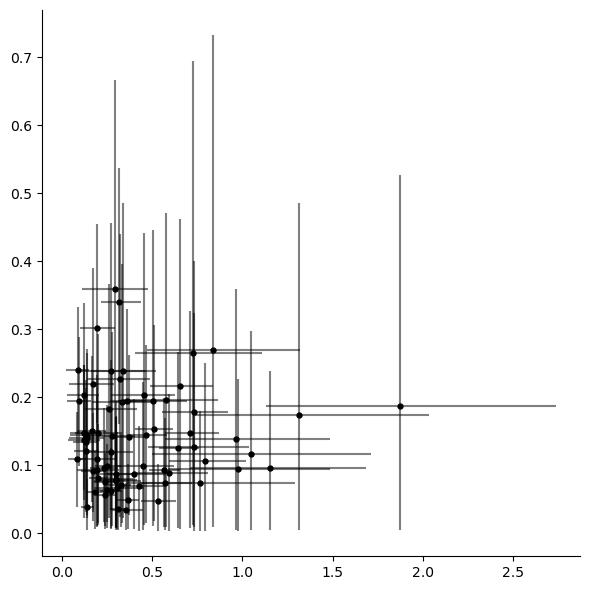

In [27]:
g = sns.FacetGrid(par_stats.unstack(['parameter']).reset_index(), height=6)

g.map_dataframe(plot_scatter_with_errors, color='k', xlabel='perceptual_noise_sd', ylabel='memory_noise_sd')

n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  73  0.091753  [-0.14, 0.32]  0.440093  0.196   
       100      pearson  73  0.062351  [-0.17, 0.29]  0.600251  0.167   
NPCr   1        pearson  73  0.013482  [-0.22, 0.24]  0.909864  0.147   
       100      pearson  73 -0.183355   [-0.4, 0.05]  0.120484  0.477   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.120779  
       100      pearson  0.081948  
NPCr   1        pearson  0.051258  
       100      pearson  0.344952

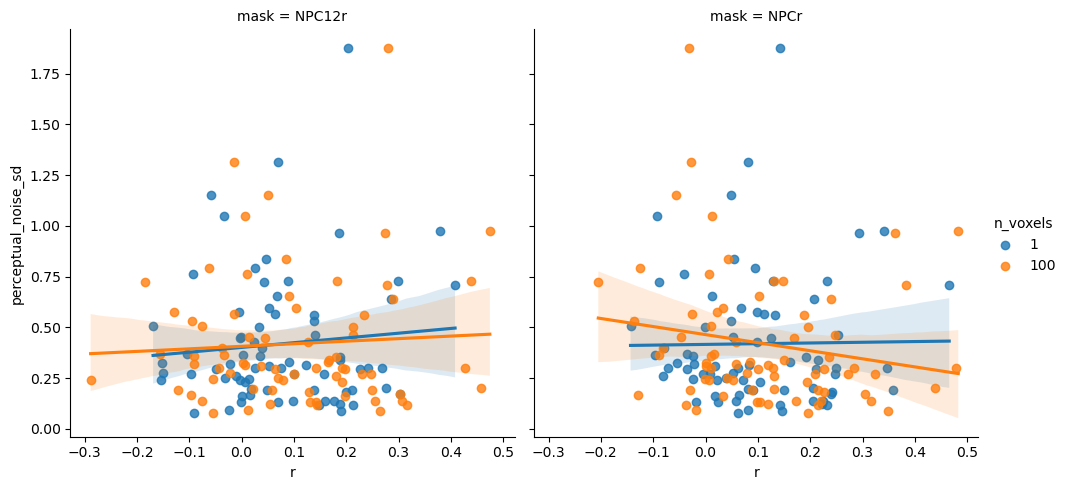

In [28]:
perceptual_noise_sd_mean = perceptual_noise_sd.groupby(['subject']).mean()
tmp = r2.join(perceptual_noise_sd_mean)
tmp['log(perceptual_noise_sd)'] = np.log(tmp['perceptual_noise_sd'])

sns.lmplot(x='r', y='perceptual_noise_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['perceptual_noise_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['perceptual_noise_sd']))

n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  73  0.071888   [-0.16, 0.3]  0.545585  0.175   
       100      pearson  73 -0.070344   [-0.3, 0.16]  0.554266  0.174   
NPCr   1        pearson  73  0.041386  [-0.19, 0.27]  0.728106  0.155   
       100      pearson  73 -0.079335   [-0.3, 0.15]  0.504652  0.182   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.092791  
       100      pearson  0.090924  
NPCr   1        pearson  0.063801  
       100      pearson  0.102418

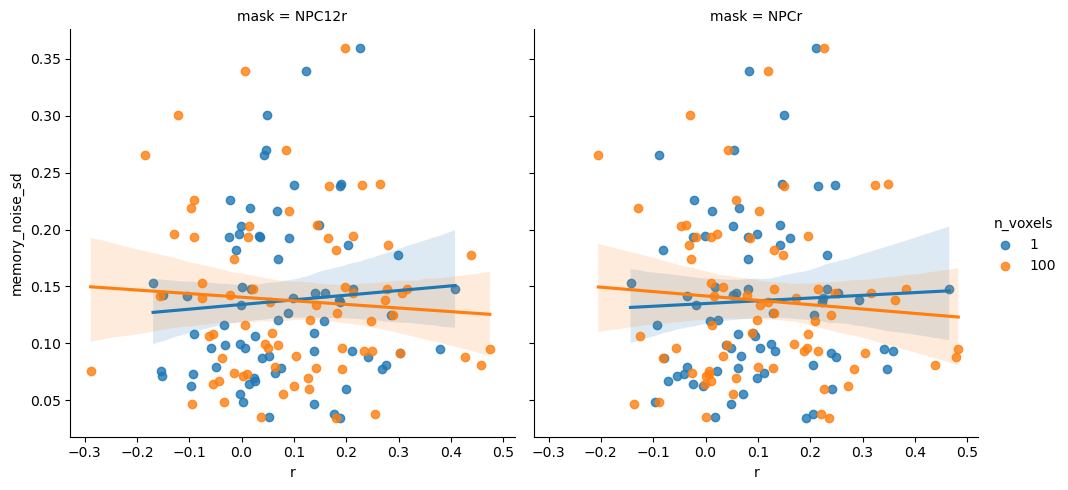

In [29]:
memory_noise_sd_mean = memory_noise_sd.groupby(['subject']).mean()
tmp = r2.join(memory_noise_sd_mean)
tmp['log(memory_noise_sd)'] = np.log(tmp['memory_noise_sd'])

sns.lmplot(x='r', y='memory_noise_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['memory_noise_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['memory_noise_sd']))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_5538/1452569080.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]


n         r           CI95%     p-val      BF10  \
mask   n_voxels                                                             
NPC12r 1        pearson  73 -0.521852  [-0.67, -0.33]  0.000002  8617.091   
       100      pearson  73 -0.328651  [-0.52, -0.11]  0.004528     7.592   
NPCr   1        pearson  73 -0.478109  [-0.64, -0.28]  0.000019  1146.974   
       100      pearson  73 -0.254915  [-0.46, -0.03]  0.029518      1.49   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.998203  
       100      pearson  0.819358  
NPCr   1        pearson  0.992261  
       100      pearson  0.592464

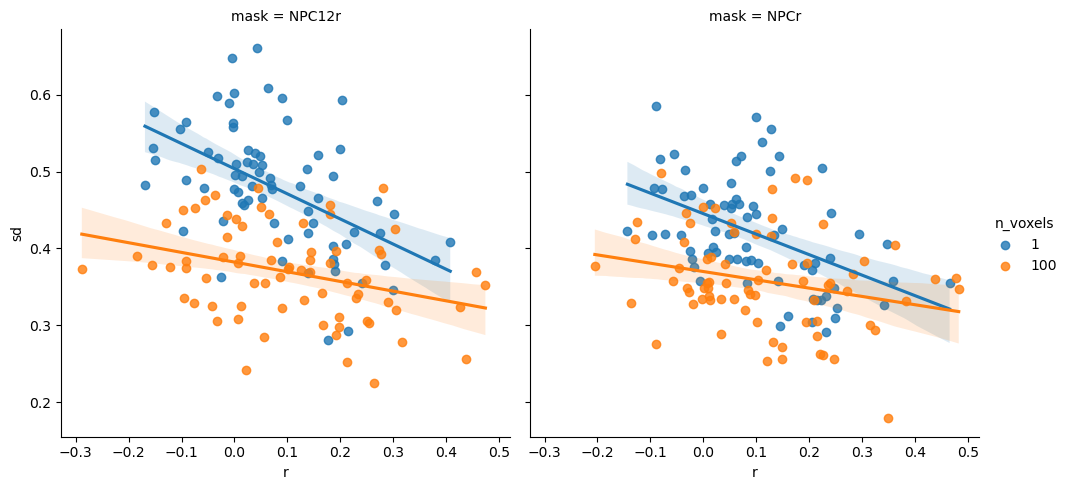

In [30]:
mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]

mean_sd = mean_sd.join(r2)

sns.lmplot(x='r', y='sd', data=mean_sd.reset_index(), hue='n_voxels', col='mask')

mean_sd.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['sd']))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_5538/3665216187.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]


n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  73  0.261856   [0.03, 0.46]  0.025228  1.702   
       100      pearson  73  0.274164   [0.05, 0.47]  0.018916  2.176   
NPCr   1        pearson  73  0.233655    [0.0, 0.44]  0.046644  1.017   
       100      pearson  73  0.163189  [-0.07, 0.38]  0.167745  0.372   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.616579  
       100      pearson  0.658420  
NPCr   1        pearson  0.517359  
       100      pearson  0.283156

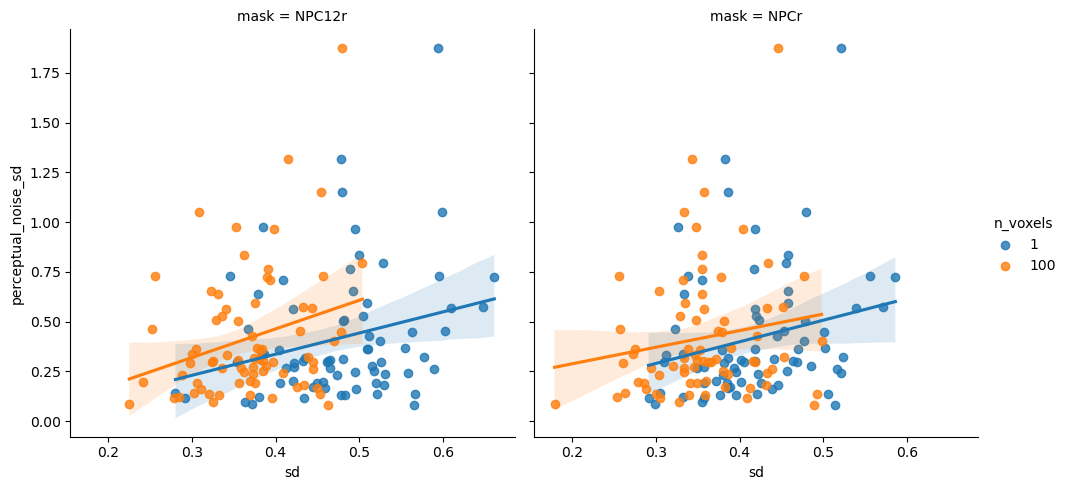

In [31]:
mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]

mean_sd = mean_sd.join(perceptual_noise_sd_mean)

sns.lmplot(x='sd', y='perceptual_noise_sd', data=mean_sd.reset_index(), hue='n_voxels', col='mask')

mean_sd.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['sd'], d['perceptual_noise_sd']))